# Picocoder
_A Raspberry Pi Pico microcode glitcher_

## Connection
We connect with the Pi Pico and setup some glitching options.

In [1]:
%matplotlib widget

POWERSUPPLY_PORT = '/dev/ttyACM0'
GLITCHER_PORT = '/dev/ttyACM1'
GLITCHER_BAUD = 115200

import struct
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib import reload # for debugging

import glitch_utils
from glitch_utils import GlitchyMcGlitchFace, GlitchResult
from power_supply import PowerSupply, KA3305P
glitch_utils = reload(glitch_utils)

try:
	del ps
	del glitcher
	del gc
except:
	pass
ps = KA3305P(port=POWERSUPPLY_PORT)
ps.con()
ps.power_cycle()

glitcher = glitch_utils.GlitchyMcGlitchFace(GLITCHER_PORT, GLITCHER_BAUD)
if not glitcher.ping():
	raise Exception("Glitcher not responding")
if not glitcher.ping_target():
	raise Exception("Target not responding")

gc = glitch_utils.GlitchController(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage'])
gc.set_range('ext_offset', 1, 10)
gc.set_range('width', 1, 10)
gc.set_range('voltage', 0b0110011, 0b1001011) # 1V-1.24V - See Table 6-3 in TPS65094 datasheet

def reset_target(ps: PowerSupply, glitcher: GlitchyMcGlitchFace, timeout: float = 1.5) -> None:
	ps.power_cycle()
	if not glitcher.ping_target(timeout):
		raise Exception("Target not responding after reset")

## Estimating glitch external offset
We obtain an estimate (in us) of the wait time between trigger and glitch.

In [2]:
if not glitcher.ping_target(1.5):
	reset_target(ps, glitcher)

glitcher.s.write(glitch_utils.P_CMD_ESTIMATE_OFFSET)
ret_data = glitcher.s.read(4)
ext_offset = struct.unpack("<i", ret_data)[0]
if ext_offset < 0:
	raise Exception("Invalid offset")
gc.set_range('ext_offset', ext_offset-20, ext_offset+10)
print(f"Estimated offset: {ext_offset}")

Estimated offset: 128


## Measure UART delay
This command is used to measure (externally) the time it takes for the Pico to
detect data on the UART RX pin and to start processing it. <br>
The debug pin (GPIO 16, shown blue) is toggled when the Pico detects data.

![Oscilloscope capture](../firmware/inject_v2/img/fast_response_time_busy_wait_on_UART_with_timeout.png)

In [3]:
glitcher.s.write(glitch_utils.P_CMD_UART_DEBUG_TOGGLE)
ret_data = glitcher.s.read(4)
result = (bool)(struct.unpack("<I", ret_data)[0])
print(f"Found trigger: {result}")

Found trigger: True


## Voltage range

Find where the CPU starts to stall. We ask the target to send 50 bytes to the
pico, and then we bring the voltage down for a fairly long time.

The target will then either behave normally or die altogether, not just stall
for some clock cycles. This test is fairly slow as it involves a lot of
external resets, but within a handful of minutes a sensible working voltage
can be identified right above the reset cluster

![Voltage range test plot (ignore the squares)](img/voltage_range_plot.png)

Here, for example, we can see that down to 59 (0b111011) the target is mostly
working, but there is a significant amount of crashed at 58 (0b111010). 59 will
then be the starting value for the glitching range.

### Oscilloscope captures
| Color | Description |
| --- | --- |
| Yellow | Target UART TX |
| Pink | PMBus/I2C SCL |
| Blue | PMBus/I2C SDA |
| Green | VCore |

#### No effect
When the voltage drop does not affect the target, it will successfully send the
50 bytes.

![Safe voltage and width](img/voltage_range_alive.png)

#### CPU halt
When the voltage is too low, the target will hang and not finish sending data.

![Too low voltage](img/voltage_range_dead.png)

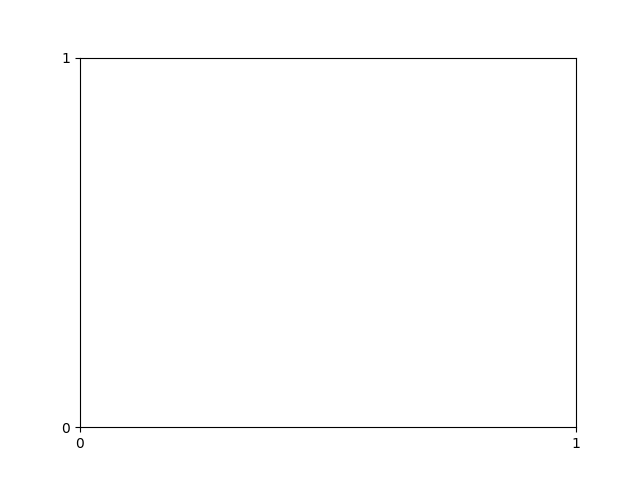

In [4]:
# NOTE This figure must be generated in a different cell than the one that calls the plot function
#	   Otherwise the plot will not be displayed until the cell is done executing (no live plot)
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [5]:
EXPECTED_BYTES = 50

gc_volt = glitch_utils.GlitchController(groups=[r.name for r in GlitchResult], parameters=['width', 'voltage'])
gc_volt.set_range('width', 1, 100)
gc_volt.set_range('voltage', 0b0110011, 0b1001011) # 1V-1.24V - See Table 6-3 in TPS65094 datasheet

glitcher.ext_offset = 500 # Offset fixed

for glitch_setting in gc_volt.rand_glitch_values():
	try:
		result, data = glitcher.find_crash_voltage(glitch_setting, EXPECTED_BYTES)

		ax.plot(*glitch_setting, result)
		fig.canvas.draw() # Guarantees live update of the plot whenever a new point is added

		if result in [GlitchResult.DEAD, GlitchResult.RESET, GlitchResult.BROKEN]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		break # Gentle stop, otherwise the plot might look empty

## Glitch loop

In [ ]:
# NOTE This figure must be generated in a different cell than the one that calls the plot function
#	   Otherwise the plot will not be displayed until the cell is done executing (no live plot)
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
for glitch_setting in gc.rand_glitch_values():
	try:
		read_result, read_data = glitcher.glitch_mul(glitch_setting, expected=0x1337)
		gc.add_result(glitch_setting, read_result)
		if read_result == GlitchResult.SUCCESS:
			print(f'Got success data: 0x{read_data.hex()}')
		if read_result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if read_result == GlitchResult.BROKEN:
			print(f'The target is in broken state: {glitch_utils.RESULT_NAMES[read_data]} (0x{int.from_bytes(read_data):x})')

		[offset, width, _] = glitch_setting
		ax.plot(offset, width, read_result)
		fig.canvas.draw() # Guarantees live update of the plot whenever a new point is added
	except KeyboardInterrupt:
		break # Gentle stop, otherwise the plot might look empty